<a href="https://colab.research.google.com/github/dfedeoli/btc2020/blob/main/BTCdesafio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: UNINASSAU

O ensino a distância (EaD) proporciona diversas novas possibilidades. Atualmente centenas de estudantes têm acesso aos mesmos conteúdos, participam das mesmas aulas e têm os mesmos professores, tudo de forma remota. Uma das grandes vantagens do EaD é a flexibilidade para que estudantes de todo o país possam trabalhar e estudar ao mesmo tempo. Entretanto, a boa e velha interação interpessoal nem sempre é possível, seja por baixa oferta de horários disponíveis para professores e tutores, ou choques de horários com trabalho e outras obrigações dos estudantes.

Atualmente é possível a realização de uma tutoria remota automática com o auxílio de assistentes virtuais. Esses assistentes podem ser integrados com modelos avançados de aprendizado de máquina, que são alimentados com dados sobre o estudante e seu desempenho nas diferentes disciplinas de seu curso. Esses modelos, por sua vez, podem ser capazes de identificar áreas ou competências específicas em que o estudante tenha certa dificuldade e recomendar conteúdo personalizado para cada aluno, de forma completamente escalável e com atendimento *24/7*.

Neste desafio, o participante deve utilizar ferramentas para construir um modelo baseado em *machine learning* com um conjunto de dados de alunos da UNINASSAU, capaz de ser integrado com uma solução de assistente virtual voltada para a tutoria remota.

Proposição completa do Desafio: https://github.com/maratonadev-br/desafio-2-2020.

## Preparação do *notebook*, obtenção e visualização dos dados

### Instalando bibliotecas

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Métodos para criação de modelos baseados em árvores de decisão e redes neurais
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Pacotes do scikit-learn para avaliação de modelos
from sklearn.metrics import classification_report

#Pacotes para balanceamento de datasets
from imblearn.over_sampling import SMOTE

### Download dos conjuntos de dados em formato .csv

In [2]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/maratonadev-br/desafio-2-2020/master/Assets/Data/dataset_desafio_2.csv
df_training_dataset = pd.read_csv(r'dataset_desafio_2.csv')
df_training_dataset.tail()

--2021-03-08 19:08:25--  https://raw.githubusercontent.com/maratonadev-br/desafio-2-2020/master/Assets/Data/dataset_desafio_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1500234 (1.4M) [text/plain]
Saving to: ‘dataset_desafio_2.csv’

dataset_desafio_2.c 100%[===================>]   1.43M  --.-KB/s    in 0.1s    

2021-03-08 19:08:26 (10.9 MB/s) - ‘dataset_desafio_2.csv’ saved [1500234/1500234]



,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
19995,856673,Laércio Mário da Silva,0,0,0,0,7.0,7.9,5.8,7.0,1.0,9,5,6,EXATAS
19996,576100,Cibele Quésia Poza,1,1,1,1,0.0,0.0,0.0,NaN,1.0,3,2,5,DIFICULDADE
19997,888739,Marcielle Chale Bape,0,0,0,0,7.9,7.6,8.3,7.2,NaN,8,3,1,EXCELENTE
19998,722743,Suzanne Mirian Mourão,0,0,1,1,6.3,5.1,0.0,0.0,1.0,3,2,6,DIFICULDADE
19999,417268,Maria Isaiane da Silva Luwequisman,0,0,1,1,7.0,7.3,0.0,0.0,NaN,3,0,6,DIFICULDADE


Temos 15 colunas presentes no *dataset* fornecido, sendo dezessete delas variáveis-características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis-características são:

    MATRICULA       - número de matrícula do estudante
    NOME            - nome completo do estudante
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    REPROVACOES_GO  - número de reprovações na disciplina de ``Gestão Operacional``
    NOTA_DE         - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    NOTA_EM         - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    NOTA_MF         - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    NOTA_GO         - média simples das notas do aluno na disciplina de ``Gestão Operacional`` (0-10)
    INGLES          - variável binária que indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não).
    H_AULA_PRES     - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE  - número de tarefas online entregues pelo estudante
    FALTAS          - número de faltas acumuladas do estudante (todas disciplinas)
    
A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "HUMANAS"        - Estudante necessita de mentoria exclusivamente em matérias com conteúdo de ciências humanas
        "EXATAS"         - Estudante necessita de mentoria apenas em disciplinas com conteúdo de ciências exatas
        "DIFICULDADE"    - Estudante necessita de mentoria em duas ou mais disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

### Explorando os dados fornecidos

Podemos continuar a exploração dos dados fornecidos com a função ``info()``:

In [3]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MATRICULA       20000 non-null  int64  
 1   NOME            20000 non-null  object 
 2   REPROVACOES_DE  20000 non-null  int64  
 3   REPROVACOES_EM  20000 non-null  int64  
 4   REPROVACOES_MF  20000 non-null  int64  
 5   REPROVACOES_GO  20000 non-null  int64  
 6   NOTA_DE         20000 non-null  float64
 7   NOTA_EM         20000 non-null  float64
 8   NOTA_MF         20000 non-null  float64
 9   NOTA_GO         16284 non-null  float64
 10  INGLES          16372 non-null  float64
 11  H_AULA_PRES     20000 non-null  int64  
 12  TAREFAS_ONLINE  20000 non-null  int64  
 13  FALTAS          20000 non-null  int64  
 14  PERFIL          20000 non-null  object 
dtypes: float64(5), int64(8), object(2)
memory usage: 2.3+ MB


É notado que existem variáveis do tipo ``float64`` (números "decimais"), variáveis do tipo ``int64`` (números inteiros) e do tipo ``object`` (nesse caso são *strings*, ou texto). 

Como a maioria dos algoritmos de aprendizado estatístico supervisionado só aceita valores numéricos como entrada, é necessário então o pré-processamento das variáveis do tipo "object" antes de usar esse dataset como entrada para o treinamento de um modelo. Também é notado que existem valores faltantes em algumas colunas (``NOTA_GO`` e ``INGLES``). Esses valores faltantes também devem ser tratados antes de serem construídos modelos com esse conjunto de dados base.

A função ``describe()`` gera várias informações sobre as variáveis numéricas que também podem ser úteis:

In [ ]:
df_training_dataset.describe()

,MATRICULA,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,16284.000000,16372.000000,20000.000000,20000.000000,20000.000000
mean,551148.271400,0.242850,0.242850,0.297650,0.293350,5.196560,5.080285,4.817630,4.534101,0.646286,5.102950,3.140300,4.060600
std,259488.766584,0.615055,0.615055,0.672813,0.661829,2.522545,2.523928,2.734775,2.509209,0.478136,4.118422,1.854909,1.674714
min,100003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,326554.250000,0.000000,0.000000,0.000000,0.000000,5.200000,4.900000,4.700000,4.500000,0.000000,2.000000,2.000000,3.000000
50%,550630.000000,0.000000,0.000000,0.000000,0.000000,6.200000,5.900000,5.500000,5.400000,1.000000,4.000000,3.000000,4.000000
75%,775524.750000,0.000000,0.000000,0.000000,0.000000,6.700000,6.700000,6.500000,6.200000,1.000000,6.000000,5.000000,6.000000
max,999995.000000,3.000000,3.000000,3.000000,3.000000,9.000000,9.400000,11.500000,10.000000,1.000000,25.000000,7.000000,8.000000


### Visualizações

Para visualizar o *dataset* fornecido, podemos utilizar as bibliotecas ``matplotlib`` e ``seaborn``:

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

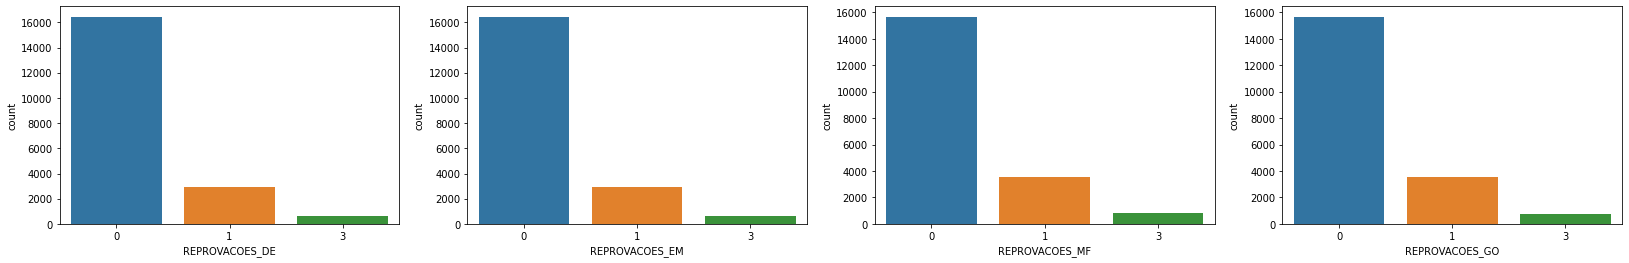

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='REPROVACOES_DE', data=df_training_dataset)
sns.countplot(ax=axes[1], x='REPROVACOES_EM', data=df_training_dataset)
sns.countplot(ax=axes[2], x='REPROVACOES_MF', data=df_training_dataset)
sns.countplot(ax=axes[3], x='REPROVACOES_GO', data=df_training_dataset)

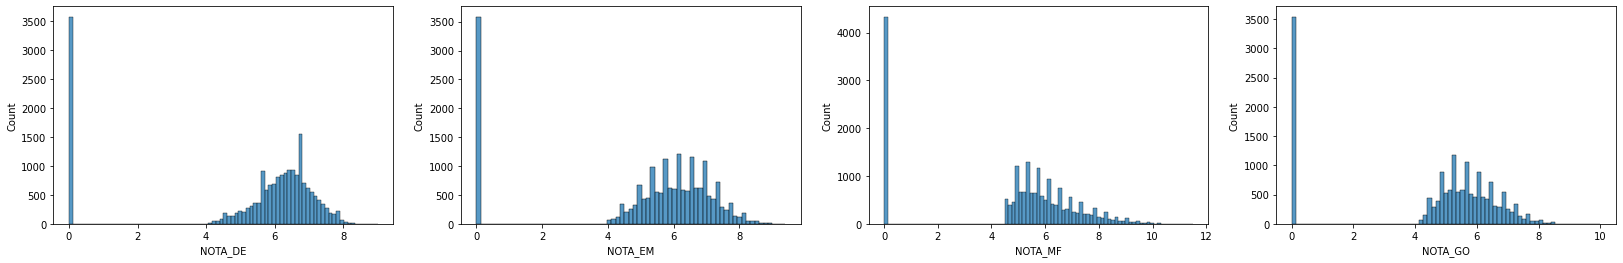

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.histplot(df_training_dataset['NOTA_DE'], ax=axes[0])
sns.histplot(df_training_dataset['NOTA_EM'], ax=axes[1])
sns.histplot(df_training_dataset['NOTA_MF'], ax=axes[2])
sns.histplot(df_training_dataset['NOTA_GO'].dropna(), ax=axes[3])

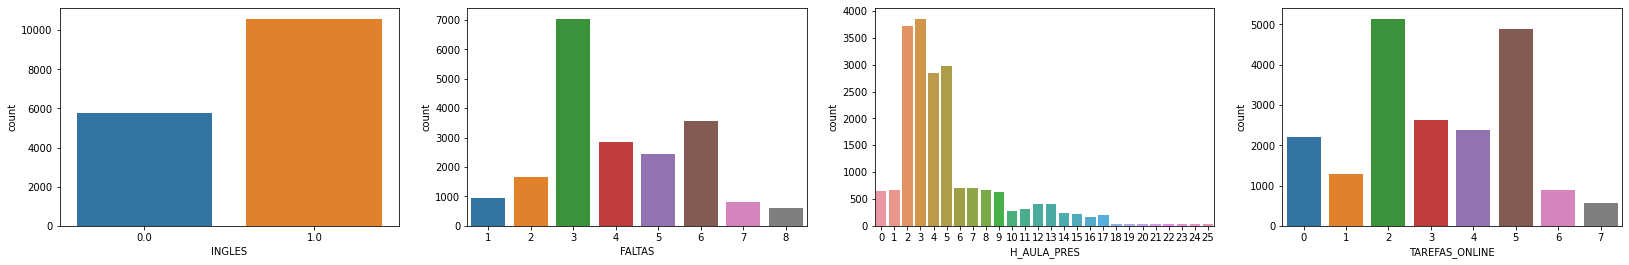

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='INGLES', data=df_training_dataset)
sns.countplot(ax=axes[1], x='FALTAS', data=df_training_dataset)
sns.countplot(ax=axes[2], x='H_AULA_PRES', data=df_training_dataset)
sns.countplot(ax=axes[3], x='TAREFAS_ONLINE', data=df_training_dataset)

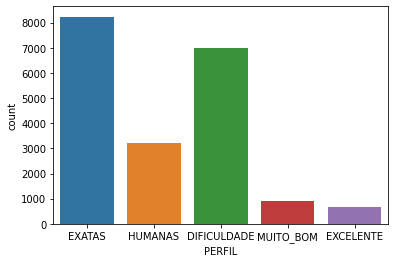

In [ ]:
fig = plt.plot()
sns.countplot(x='PERFIL', data=df_training_dataset)

A partir do gráfico acima, fica evidente que o *dataset* está **desbalanceado**, possuindo uma quantidade muito maior de estudantes com perfil ``EXATAS`` e ``DIFICULDADE``.

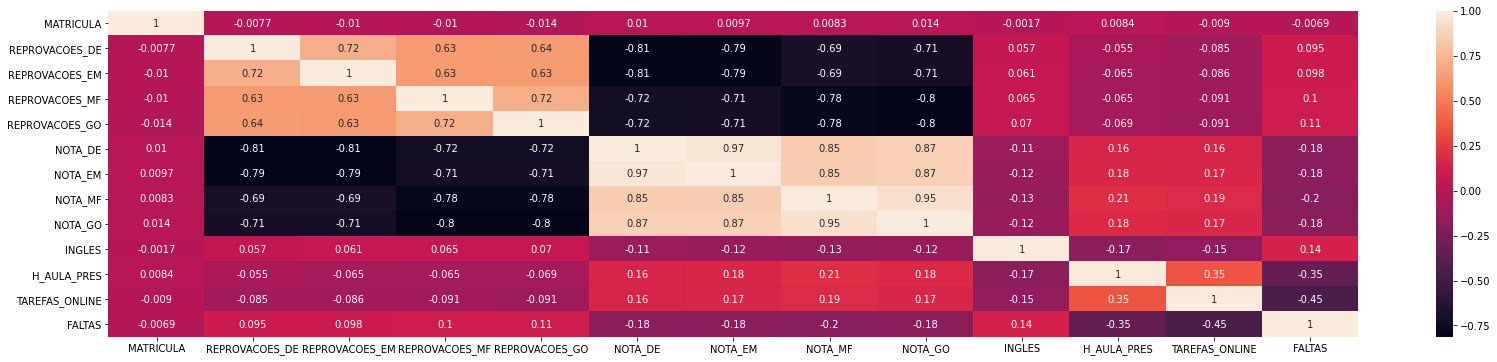

In [ ]:
plt.figure(figsize=(28, 6))
corrMatrix = df_training_dataset.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Pela matriz de correlação é possível visualizar a óbvia correlação, inversamente proporcional, entre notas e reprovações.

## Iniciando o pré-processamento dos dados

### Transformação 1: excluindo colunas do dataset

As colunas ``MATRICULA`` e ``NOME`` são removidas pelo fato de serem características únicas de cada estudante. Já as colunas referentes às reprovações são retiradas pela já citada relação com as notas baixas. As colunas ``INGLES``,``FALTAS``, ``H_AULA_PRES`` e ``TAREFAS_ONLINE`` foram retiradas arbitrariamente, visto que mesmo que possuam relação com dificuldade nas matérias, o que realmente reflete a necessidade de ajuda são as notas em cada um dos cursos.

Para aplicar essa transformação em um DataFrame pandas, basta utilizar a função ``drop``, explicitar o nome das colunas e definir ``axis=1``.

In [5]:
# Visualizando as colunas do dataset original
print("Colunas do dataset original: \n")
print(df_training_dataset.columns)

Colunas do dataset original: 

Index(['MATRICULA', 'NOME', 'REPROVACOES_DE', 'REPROVACOES_EM',
       'REPROVACOES_MF', 'REPROVACOES_GO', 'NOTA_DE', 'NOTA_EM', 'NOTA_MF',
       'NOTA_GO', 'INGLES', 'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS',
       'PERFIL'],
      dtype='object')


In [6]:
# # Aplicando a remoção de colunas do conjunto de dados base
df_training_dataset_2 = df_training_dataset.drop(['MATRICULA', 'NOME', 'INGLES', 'REPROVACOES_DE',
                          'REPROVACOES_MF', 'REPROVACOES_EM', 'REPROVACOES_GO',
                          'FALTAS', 'H_AULA_PRES', 'TAREFAS_ONLINE'],axis=1)

In [8]:
# Visualizando as colunas do dataset transformado
print("Colunas do dataset após a transformação: \n")
print(df_training_dataset_2.columns)

Colunas do dataset após a transformação: 

Index(['NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'PERFIL'], dtype='object')


### Transformação 2: criando novos *features*

Na próxima célula é apresentado o código completo de uma transformação ``CombMedia``, para o cálculo da média de um conjunto de notas escolhido do DataFrame pandas. A função será utilizada para calcular as médias geral, de humanas e de exatas.

Para a criação de uma transformação de dados personalizada no scikit-learn, é necessária basicamente a criação de uma classe com os métodos ``transform`` e ``fit``. No método transform será executada a lógica da nossa transformação.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class CombMedias(BaseEstimator, TransformerMixin):
    def __init__(self, columns, name):
        self.columns = columns
        self.name = name

    def fit(self, X, y=None):
        return self
      
    def comb(self, data):
        return pd.Series([
        np.sum([data[nota] for nota in self.columns])/len(self.columns)], index =[f'COMB_{self.name}']
        )
          
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        data = data.join(data.apply(self.comb, axis=1))
        return data

Serão calculadas as médias das notas de humanas, de exatas e a média geral de cada aluno, com a utilização da função ``CombMedias``, criada anteriormente. Mas antes de efetuar estes cálculos é necessário tratar os valores faltantes, e temos três opções de tratamento para utilizar.

In [ ]:
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_EM', 'NOTA_GO'], 'NOTAS')
ch = CombMedias(['NOTA_DE', 'NOTA_EM'], 'HUMANAS')
ce = CombMedias(['NOTA_MF', 'NOTA_GO'], 'EXATAS')

## Tratando valores faltantes e treinando modelos de predição

### Opção 1: Removendo linhas com valores faltantes

Neste primeiro modelo, as linhas com dados faltantes serão deletadas ao invés de preenchê-los, com a ajuda da função ``dropna()``. Em seguida, são aplicados os cálculos de médias já explicitados anteriormente. Nos próximos modelos, utilizaremos a função ``SimpleImputer`` para preenchimento de dados faltantes com valores médios ou constantes. 



In [ ]:
df_training_dataset_drop = df_training_dataset_2.dropna()
df_training_dataset_3 = pd.DataFrame.from_records(cm.fit_transform(df_training_dataset_drop))
df_training_dataset_4 = pd.DataFrame.from_records(ch.fit_transform(df_training_dataset_3))
df_training_dataset_5 = pd.DataFrame.from_records(ce.fit_transform(df_training_dataset_4))

As próximas células permitem a visualização do dataset que será utilizado para treinamento do modelo preditivo, com suas novas colunas e um número reduzido de linhas.

In [ ]:
df_training_dataset_5.head()

,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,PERFIL,COMB_NOTAS,COMB_HUMANAS,COMB_EXATAS
0,6.2,5.8,4.6,5.9,EXATAS,5.625,6.0,5.25
1,6.0,6.2,5.2,4.5,EXATAS,5.475,6.1,4.85
2,7.3,6.7,7.1,7.2,HUMANAS,7.075,7.0,7.15
3,0.0,0.0,0.0,0.0,DIFICULDADE,0.000,0.0,0.00
4,0.0,0.0,0.0,0.0,DIFICULDADE,0.000,0.0,0.00


In [ ]:
df_training_dataset_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16284 entries, 0 to 16283
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NOTA_DE       16284 non-null  float64
 1   NOTA_EM       16284 non-null  float64
 2   NOTA_MF       16284 non-null  float64
 3   NOTA_GO       16284 non-null  float64
 4   PERFIL        16284 non-null  object 
 5   COMB_NOTAS    16284 non-null  float64
 6   COMB_HUMANAS  16284 non-null  float64
 7   COMB_EXATAS   16284 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1017.9+ KB


Nota-se que não temos mais nenhum valor faltante no nosso conjunto de dados, mas o tamanho do *dataset* diminuiu em mais de 15%.


#### Definindo as features do modelo

Finalizado o pré-processamento, já temos o conjunto de dados no formato necessário para o treinamento do nosso modelo. Iremos utilizar todas as colunas, exceto a coluna **PERFIL**, como *features* (variáveis de entrada).

A variável **PERFIL** será a variável-alvo do modelo, conforme descrito no enunciado do desafio.

In [ ]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'COMB_NOTAS','COMB_HUMANAS','COMB_EXATAS'
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_training_dataset_5[features]
y = df_training_dataset_5[target]

O conjunto de entrada (X):

In [ ]:
X.head()

,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,COMB_NOTAS,COMB_HUMANAS,COMB_EXATAS
0,6.2,5.8,4.6,5.9,5.625,6.0,5.25
1,6.0,6.2,5.2,4.5,5.475,6.1,4.85
2,7.3,6.7,7.1,7.2,7.075,7.0,7.15
3,0.0,0.0,0.0,0.0,0.000,0.0,0.00
4,0.0,0.0,0.0,0.0,0.000,0.0,0.00


As variáveis-alvo correspondentes (y):

In [ ]:
y.head()

,PERFIL
0,EXATAS
1,EXATAS
2,HUMANAS
3,DIFICULDADE
4,DIFICULDADE


#### Separando o dataset em um conjunto de treino e um conjunto de teste

Iremos separar o *dataset* fornecido em dois grupos: um para treinar nosso modelo, e outro para testarmos o resultado através de um teste cego. A separação do *dataset* pode ser feita facilmente com o método *train_test_split()* do scikit-learn:

In [ ]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X = X.to_numpy()
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=82)

Como todas colunas tem valores variando entre 0 e 10, não há necessidade de escaloná-las com a função ``sklearn.preprocessing.StandardScaler()``. Ela é importante para tratar *features* numéricos que possuem diferentes ordens de grandeza.

Podem ser utilizadas algumas técnicas de balanceamento do dataset, por *over-sampling* e *under-sampling*. Neste caso, será utilizado o *SMOTE*, uma técnica de *over-sampling* para categorias minoritárias.

In [ ]:
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(n_jobs=2,random_state=132)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### Criando modelos baseados em redes neurais *MLP* e *XGBoost*

Criaremos classificadores baseados em **MLPClassifier** e em **XGBClassifier**. O critério principal para escolha do modelo será o conjunto de *F1-Scores* dos perfis.

Material teórico sobre redes neurais na documentação oficial do scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html, e sobre XGBClassifier na documentação oficial do XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html.

O primeiro passo é basicamente instanciar um objeto *MLPClassifier* da biblioteca scikit-learn.

##### *Testando o classificador de rede neural MLPClassifier*

O modelo é definido com parâmetros arbitrários e o método ``fit`` é aplicado para ajustar o modelo ao conjunto de treino. Em seguida, o modelo é utilizado para predição dos valores **PERFIL** (``y_pred``) baseado no conjunto de teste ``X_test``, para futura comparação com os valores verdadeiros ``y_test``.

In [ ]:
mlp_model_1 =  MLPClassifier(hidden_layer_sizes=(50, 50, 50),activation='logistic', solver='adam',learning_rate='invscaling',alpha=0)

In [ ]:
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
mlp_model_1.fit(
    X_train,
    y_train
)
# Realização de teste cego no modelo criado
y_pred = mlp_model_1.predict(X_test)

In [ ]:
print(y_pred)

['EXCELENTE' 'DIFICULDADE' 'HUMANAS' ... 'EXCELENTE' 'EXATAS'
 'DIFICULDADE']


Na célula seguinte, criamos uma função para a plotagem de uma matriz de confusão, facilitando a visualização dos resultados de predição em relação aos valores reais de teste.

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

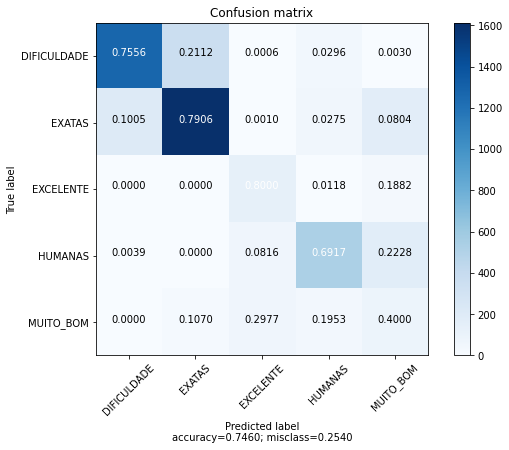

              precision    recall  f1-score   support

 DIFICULDADE       0.86      0.76      0.80      1690
      EXATAS       0.81      0.79      0.80      2039
   EXCELENTE       0.51      0.80      0.62       170
     HUMANAS       0.78      0.69      0.73       772
   MUITO_BOM       0.19      0.40      0.26       215

    accuracy                           0.75      4886
   macro avg       0.63      0.69      0.64      4886
weighted avg       0.78      0.75      0.76      4886



In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['DIFICULDADE', 'EXATAS', 'EXCELENTE', 'HUMANAS', 'MUITO_BOM'])
print(classification_report(y_test, y_pred))

Pela matriz de confusão, fica claro que o maior problema é a previsão correta do *label* ``MUITO_BOM``. As maiores taxas de acerto estão nos perfis que possuem a maior quantidade de dados, ``DIFICULDADE`` e ``EXATAS``. Os outros três perfis acabam se confudindo muito e gerando maiores taxas de erro.

Apesar dos valores de precisão (*precision*) e revocação (*recall*) do perfil ``MUITO_BOM`` no relatório de classificação serem baixos, eles são muito melhores se comparados a modelos que não utilizam a técnica de balanceamento *SMOTE*. Sem esta técnica a acurácia geral é maior, mas os perfis em quantidade minoritária sofrem muito e os modelos se tornam menos representativos.

##### *Testando o classificador XGBClassifier*

Aplicamos as mesmas etapas do modelo anterior para a predição baseada em XGBoost.

In [ ]:
xgb_model_1 = xgb.XGBClassifier(objective='multi:logistic',n_jobs=2)
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
xgb_model_1.fit(
    X_train,
    y_train
)
# Realização de teste cego no modelo criado
y_pred = xgb_model_1.predict(X_test)

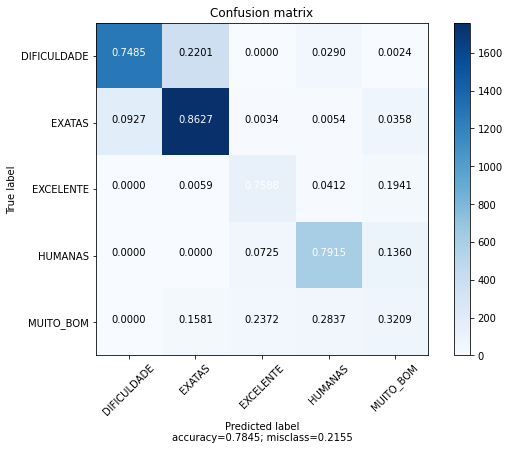

              precision    recall  f1-score   support

 DIFICULDADE       0.87      0.75      0.80      1690
      EXATAS       0.81      0.86      0.84      2039
   EXCELENTE       0.53      0.76      0.62       170
     HUMANAS       0.83      0.79      0.81       772
   MUITO_BOM       0.24      0.32      0.28       215

    accuracy                           0.78      4886
   macro avg       0.66      0.70      0.67      4886
weighted avg       0.80      0.78      0.79      4886



In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['DIFICULDADE', 'EXATAS', 'EXCELENTE', 'HUMANAS', 'MUITO_BOM'])
print(classification_report(y_test, y_pred))

Tanto a acurácia do modelo XGBoost quanto os valores de *F1-Score* para cada perfil são melhores do que os do modelo MLP. Daqui em frente utilizaremos apenas este modelo.

<hr>

### Opção 2: Preenchendo valores faltantes com valores médios

Outra opção para tratarmos os dados faltantes do *dataframe* é, para cada coluna, inserir a média dos valores existentes em suas células vazias. Para isto, utilizaremos as funções ``SimpleImputer`` (com ``strategy='mean'``) e ``ColumnTransformer``. Neste caso, apenas a coluna ``NOTA_GO`` será alterada pois é a única que possui valores faltantes.

In [ ]:
from sklearn.compose import ColumnTransformer
#inserção de valores médios das colunas nas células vazias
t_mean = [('num', SimpleImputer(missing_values=np.NaN, strategy='mean'), [0,1,2,3])]
transformer_mean = ColumnTransformer(transformers=t_mean, remainder='passthrough')

In [ ]:
# Visualizando os dados faltantes do dataset após a primeira transformação (df_training_dataset_2)
print("Valores nulos antes da transformação SimpleImputer: \n\n{}\n".format(df_training_dataset_2.isnull().sum(axis = 0)))

Valores nulos antes da transformação SimpleImputer: 

NOTA_DE       0
NOTA_EM       0
NOTA_MF       0
NOTA_GO    3716
PERFIL        0
dtype: int64



In [ ]:
# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_training_dataset_2 (resultado da primeira transformação)
# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_mean)
df_data_mean = pd.DataFrame.from_records(
    data=transformer_mean.fit_transform(X=df_training_dataset_2),columns=df_training_dataset_2.columns,index=df_training_dataset_2.index)

In [ ]:
# Visualizando os dados faltantes do dataset após a segunda transformação (SimpleImputer) (df_data_mean)
print("Valores nulos no dataset após a transformação SimpleImputer: \n\n{}\n".format(df_data_mean.isnull().sum(axis = 0)))

Valores nulos no dataset após a transformação SimpleImputer: 

NOTA_DE    0
NOTA_EM    0
NOTA_MF    0
NOTA_GO    0
PERFIL     0
dtype: int64



Após o tratamento dos valores faltantes, podemos criar as *features* relacionadas às médias das notas:

In [ ]:
# Médias das notas em geral, das matérias de humanas e das matérias de exatas 
df_training_dataset_3 = pd.DataFrame.from_records(cm.fit_transform(df_data_mean))
df_training_dataset_4 = pd.DataFrame.from_records(ch.fit_transform(df_training_dataset_3))
df_training_dataset_5 = pd.DataFrame.from_records(ce.fit_transform(df_training_dataset_4))

Desta forma, o *dataset* final é representado a seguir.

In [ ]:
df_training_dataset_5.head()

,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,PERFIL,COMB_NOTAS,COMB_HUMANAS,COMB_EXATAS
0,6.2,5.8,4.6,5.9,EXATAS,5.625,6.0,5.25
1,6.0,6.2,5.2,4.5,EXATAS,5.475,6.1,4.85
2,7.3,6.7,7.1,7.2,HUMANAS,7.075,7.0,7.15
3,0.0,0.0,0.0,0.0,DIFICULDADE,0.000,0.0,0.00
4,0.0,0.0,0.0,0.0,DIFICULDADE,0.000,0.0,0.00


Desta vez, o dataset possui 20000 linhas e não possui valores faltantes:

In [ ]:
df_training_dataset_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NOTA_DE       20000 non-null  float64
 1   NOTA_EM       20000 non-null  float64
 2   NOTA_MF       20000 non-null  float64
 3   NOTA_GO       20000 non-null  float64
 4   PERFIL        20000 non-null  object 
 5   COMB_NOTAS    20000 non-null  float64
 6   COMB_HUMANAS  20000 non-null  float64
 7   COMB_EXATAS   20000 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.2+ MB


Realiza-se a separação dos conjuntos de treino e de teste e o balanceamento do conjunto de treino:

In [ ]:
# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_training_dataset_5[features].to_numpy()
y = df_training_dataset_5[target].to_numpy()

In [ ]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=82) 
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(n_jobs=2,random_state=132)
X_train, y_train = smote.fit_resample(X_train, y_train)

Aplicação do modelo *XGBClassifier*, já que ele garantiu um modelo de predição melhor que o *MLPClassifier* na [seção anterior](https://colab.research.google.com/drive/10j1JKwMHfbRQT0yMhmd3l2LxgTzACwFr?authuser=1#scrollTo=dXpevw899zP-&line=3&uniqifier=1).

In [ ]:
xgb_model_2= xgb.XGBClassifier(objective='multi:logistic',n_jobs=2)
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
xgb_model_2.fit(
    X_train,
    y_train
)
# Realização de teste cego no modelo criado
y_pred = xgb_model_2.predict(X_test)

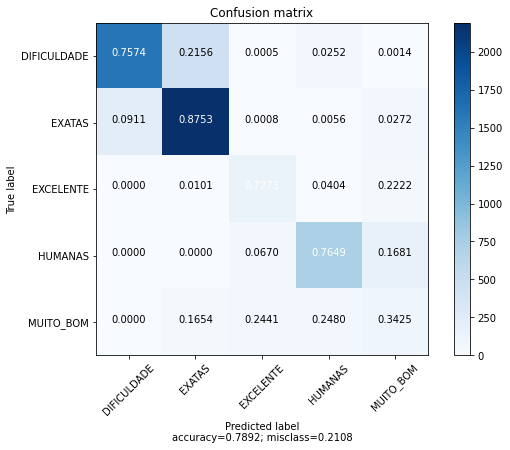

              precision    recall  f1-score   support

 DIFICULDADE       0.87      0.76      0.81      2106
      EXATAS       0.81      0.88      0.84      2502
   EXCELENTE       0.53      0.73      0.61       198
     HUMANAS       0.84      0.76      0.80       940
   MUITO_BOM       0.24      0.34      0.28       254

    accuracy                           0.79      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.81      0.79      0.79      6000



In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['DIFICULDADE', 'EXATAS', 'EXCELENTE', 'HUMANAS', 'MUITO_BOM'])
print(classification_report(y_test, y_pred))

Se comparado ao modelo *XGBoost* com remoção de linhas, houve uma pequena melhoria na acurácia (de 78 para 79%), mas os valores de *F1-Score* pouco variaram.

### Opção 3: Preenchendo com valores constantes igual a zero

Nesta última opção de tratamento de valores faltantes, substituiremos as células vazias por 0 (zero). Esta é uma opção interessante caso o motivo dos valores faltantes fosse por ausência do estudante nos dias das provas, mas não sabemos se este é o caso. De qualquer forma, aplicaremos este método para avaliá-lo como opção.

Utilizaremos novamente as funções ``SimpleImputer`` (desta vez com parâmetros ``strategy='constant'`` e ``fill_value=0``) e ``ColumnTransformer``.

In [ ]:
#transformação dos valores faltantes com a inserção de valor constante e igual a zero
t_csnt = [('num', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0), [0,1,2,3])]
transformer_csnt = ColumnTransformer(transformers=t_csnt, remainder='passthrough')

In [ ]:
# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_training_dataset_2 (resultado da primeira transformação)
# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_cnst)
df_data_cnst = pd.DataFrame.from_records(
    data=transformer_csnt.fit_transform(X=df_training_dataset_2),columns=df_training_dataset_2.columns,index=df_training_dataset_2.index)

Em seguida realizamos os procedimentos restantes: aplicamos as transformações restantes, separamos o *dataset* em conjunto de treino e de teste, balanceamos o *training set* e aplicamos o modelo.

In [ ]:
# Médias das notas em geral, das matérias de humanas e das matérias de exatas 
df_training_dataset_3 = pd.DataFrame.from_records(cm.fit_transform(df_data_cnst))
df_training_dataset_4 = pd.DataFrame.from_records(ch.fit_transform(df_training_dataset_3))
df_training_dataset_5 = pd.DataFrame.from_records(ce.fit_transform(df_training_dataset_4))

In [ ]:
# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_training_dataset_5[features].to_numpy()
y = df_training_dataset_5[target].to_numpy()

In [ ]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=82)
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(n_jobs=2,random_state=132)
X_train, y_train = smote.fit_resample(X_train, y_train) 

In [ ]:
xgb_model_3 = xgb.XGBClassifier(objective='multi:logistic',n_jobs=2)
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
xgb_model_3.fit(
    X_train,
    y_train
)
# Realização de teste cego no modelo criado
y_pred = xgb_model_3.predict(X_test)

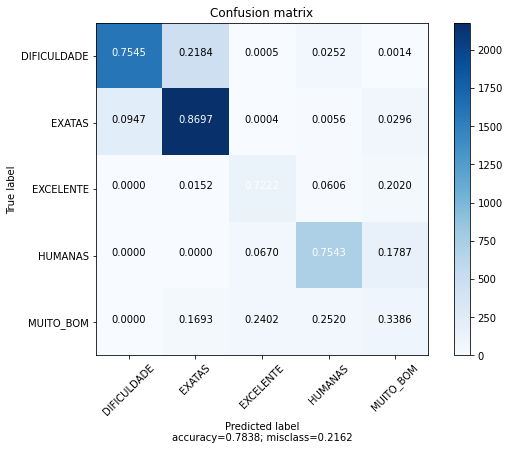

              precision    recall  f1-score   support

 DIFICULDADE       0.87      0.75      0.81      2106
      EXATAS       0.81      0.87      0.84      2502
   EXCELENTE       0.53      0.72      0.61       198
     HUMANAS       0.83      0.75      0.79       940
   MUITO_BOM       0.23      0.34      0.28       254

    accuracy                           0.78      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.80      0.78      0.79      6000



In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['DIFICULDADE', 'EXATAS', 'EXCELENTE', 'HUMANAS', 'MUITO_BOM'])
print(classification_report(y_test, y_pred))

A acurácia deste modelo retorna a 78% e os valores *F1-Score* pouco mudam novamente.

## Seleção do modelo a ser utilizado

Como a diminuição do tamanho do *dataset*, comparado ao preenchimento das células vazias do *dataframe*, pouco afeta a acurácia e os valores *F1-Score* entre os modelos, o modelo utilizado será o primeiro dos *XGBClassifiers*. Presumir os valores das células vazias pode ser prejudicial ao modelo, pois não se sabe exatamente o motivo da ausência destes valores, podendo os valores inseridos gerarem um grande erro.

**Modelo para submissão do desafio: ``xgb_model_1``.**

<hr>

## Scoring dos dados necessários para entregar a solução

Como entrega da solução, espera-se os resultados classificados no seguinte *dataset*, chamado "to_be_scored.csv":

### Download da "folha de respostas"

In [ ]:
import urllib.request
url = 'https://raw.githubusercontent.com/vanderlei-test/dataset-uninassau/master/to_be_scored_uninassau.csv'
filename = 'to_be_scored_uninassau.csv'
urllib.request.urlretrieve(url, filename)
    
df_to_be_scored = pd.read_csv(r'to_be_scored_uninassau.csv')
df_to_be_scored.tail()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
495,940576,Samuel Bahia Cranulunan,0,0,0,0,6.3,5.3,7.0,5.6,1,4,0,8
496,682956,Samuel de Linhares,0,0,0,0,5.7,5.9,5.8,5.0,1,1,1,6
497,850896,Gigi Olga de Oliveira,0,0,0,0,6.7,7.1,5.7,6.3,0,16,6,3
498,525876,Marta Oaman,0,0,0,0,6.7,7.2,5.2,5.7,1,10,3,5
499,867666,Eliel Jardel da Costa Sanches,0,0,0,0,7.1,6.8,6.5,6.0,1,5,3,6


O *dataframe* ``to_be_scored`` é a "folha de respostas". A coluna **PERFIL** não existe nessa amostra, que não pode ser então utilizada para treino de modelos de aprendizado supervisionado.

In [ ]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MATRICULA       500 non-null    int64  
 1   NOME            500 non-null    object 
 2   REPROVACOES_DE  500 non-null    int64  
 3   REPROVACOES_EM  500 non-null    int64  
 4   REPROVACOES_MF  500 non-null    int64  
 5   REPROVACOES_GO  500 non-null    int64  
 6   NOTA_DE         500 non-null    float64
 7   NOTA_EM         500 non-null    float64
 8   NOTA_MF         500 non-null    float64
 9   NOTA_GO         500 non-null    float64
 10  INGLES          500 non-null    int64  
 11  H_AULA_PRES     500 non-null    int64  
 12  TAREFAS_ONLINE  500 non-null    int64  
 13  FALTAS          500 non-null    int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 54.8+ KB


Para poder aplicar o modelo e classificar a folha de respostas, é preciso primeiro aplicar as mesmas transformações com colunas aplicadas no *dataset* de treino. Nenhuma linha deste *dataset* será deletada pois esta é a folha de respostas e a submissão do desafio exige todas as linhas para avaliação. 

Na célula abaixo, repetimos rapidamente os mesmos passos de pré-processamento usados no *dataset* de treino.


In [ ]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df_to_be_scored)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)
#cálculo das médias
df_to_be_scored_3 = pd.DataFrame.from_records(cm.fit_transform(df_to_be_scored_2))
df_to_be_scored_4 = pd.DataFrame.from_records(ch.fit_transform(df_to_be_scored_3))
df_to_be_scored_5 = pd.DataFrame.from_records(ce.fit_transform(df_to_be_scored_4))

df_to_be_scored_5.tail()

,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,COMB_NOTAS,COMB_HUMANAS,COMB_EXATAS
495,6.3,5.3,7.0,5.6,6.05,5.80,6.30
496,5.7,5.9,5.8,5.0,5.60,5.80,5.40
497,6.7,7.1,5.7,6.3,6.45,6.90,6.00
498,6.7,7.2,5.2,5.7,6.20,6.95,5.45
499,7.1,6.8,6.5,6.0,6.60,6.95,6.25


Pode ser verificado abaixo que as colunas da folha de resposta agora são idênticas às que foram usadas para treinar o modelo:

In [ ]:
df_to_be_scored_5.columns

Index(['NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'COMB_NOTAS',
       'COMB_HUMANAS', 'COMB_EXATAS'],
      dtype='object')

### Executando as predições na "folha de respostas"

Fazendo a previsão dos valores ``target`` com o modelo ``xgb_model_1`` e adicionando-os à folha de resposta, obtêm-se:

In [ ]:
y_pred = xgb_model_1.predict(df_to_be_scored_5.to_numpy())
df_to_be_scored_5['target'] = y_pred
df_to_be_scored_5.tail()

,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,COMB_NOTAS,COMB_HUMANAS,COMB_EXATAS,target
495,6.3,5.3,7.0,5.6,6.05,5.80,6.30,HUMANAS
496,5.7,5.9,5.8,5.0,5.60,5.80,5.40,EXATAS
497,6.7,7.1,5.7,6.3,6.45,6.90,6.00,EXATAS
498,6.7,7.2,5.2,5.7,6.20,6.95,5.45,EXATAS
499,7.1,6.8,6.5,6.0,6.60,6.95,6.25,EXATAS


### Salvando a folha de respostas como um arquivo .csv para ser submetido

O arquivo a ser submetido deve ter o nome "results.csv", então a folha de respostas é transformada em um arquivo CSV da seguinte maneira:

In [ ]:
df_to_be_scored_5.to_csv('results.csv',index=False)

Pronto! A folha de respostas está pronta para ser submetida com os resultados obtidos pelo modelo de aprendizado de máquina criado.